# Running GraphEM with the Command Line Interface (CLI)

In this tutorial, we first run through a demo case with the GraphEM method in a notebook style, after which we generate the configurations file `configs.yml` based on the demo case.

Then we repeat the case by calling the `ReconJob.run_graphem_cfg()` method using the `configs.yml` in a notebook style.

Finally, we repeat the case by calling the command line interface using the `configs.yml`.

A validation section is presented in the end to make sure the reconstruction job yields a reasonable result.

## Generating the `configs.yml` file

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
print(cfr.__version__)

2023.7.21


In [2]:
job = cfr.ReconJob()
job.load_proxydb('PAGES2kv2')

In [3]:
job.filter_proxydb(by='ptype', keys=['coral'])
job.annualize_proxydb(months=[12, 1, 2], ptypes=['coral'])

# obs: fetching & preprocessing
job.load_clim(tag='obs', path_dict={'tas': 'gistemp1200_GHCNv4_ERSSTv5'}, anom_period=[1951, 1980], rename_dict={'tas': 'tempanomaly'})

# obs: processing
job.annualize_clim(tag='obs', months=[12, 1, 2])
job.regrid_clim(tag='obs', nlat=42, nlon=63)
job.crop_clim(tag='obs', lat_min=-20, lat_max=20, lon_min=150, lon_max=260)

Annualizing ProxyDatabase: 100%|██████████| 104/104 [00:02<00:00, 45.02it/s]


>>> The target file seems existed at: ./data/gistemp1200_GHCNv4_ERSSTv5.nc.gz . Loading from it instead of downloading ...


In [4]:
job.prep_graphem(
    recon_period=(1871, 2000),  # period to reconstruct
    calib_period=(1901, 2000),  # period for calibration
    uniform_pdb=True,           # filter the proxydb to be more uniform
    verbose=True,
)

>>> job.configs["recon_period"] = [1871, 2000]
>>> job.configs["recon_timescale"] = 1
>>> job.configs["calib_period"] = [1901, 2000]
>>> job.configs["uniform_pdb"] = True
>>> ProxyDatabase filtered to be more uniform. 54 records remaining.
>>> job.configs["proxydb_center_ref_period"] = [1901, 2000]


Centering each of the ProxyRecord: 100%|██████████| 54/54 [00:00<00:00, 2010.35it/s]

>>> job.proxydb updated
>>> job.graphem_params["recon_time"] created
>>> job.graphem_params["calib_time"] created


>>> job.graphem_params["field_obs"] created
>>> job.graphem_params["calib_idx"] created
>>> job.graphem_params["field"] created
>>> job.graphem_params["df_proxy"] created
>>> job.graphem_params["proxy"] created
>>> job.graphem_params["lonlat"] created


In [5]:
%%time

# GraphEM
job.run_graphem(
    save_dirpath='./recons/test-run-graphem-cfg',
    graph_method='hybrid',
    cutoff_radius=1500,
    sp_FF=3, sp_FP=4,
    verbose=True,
)

>>> job.configs["compress_params"] = {'zlib': True}
>>> job.configs["save_dirpath"] = ./recons/test-run-graphem-cfg
>>> job.configs["save_filename"] = job_r01_recon.nc
>>> job.configs["graph_method"] = hybrid
>>> job.configs["cutoff_radius"] = 1500
>>> job.configs["sp_FF"] = 3
>>> job.configs["sp_FP"] = 4
Computing a neighborhood graph with R = 1500.0 km
Estimating graph using neighborhood method
Running GraphEM:



EM | dXmis: 0.0026; rdXmis: 0.0046:   4%|▍         | 9/200 [03:14<1:08:54, 21.64s/it]


GraphEM.EM(): Tolerance achieved.
Solving graphical LASSO using greedy search


graph_greedy_search | FF:  3.720; FP:  3.644; PP:  0.000:   3%|▎         | 17/500 [00:01<00:50,  9.61it/s]


Using specified graph
Running GraphEM:



EM | dXmis: 0.0021; rdXmis: 0.0049:   8%|▊         | 15/200 [05:27<1:07:19, 21.83s/it]

GraphEM.EM(): Tolerance achieved.
>>> job.graphem_solver created and saved to: None
>>> job.recon_fields created
>>> Reconstructed fields saved to: ./recons/test-run-graphem-cfg/job_r01_recon.nc
CPU times: user 48min 15s, sys: 50min 29s, total: 1h 38min 45s
Wall time: 8min 44s


In [6]:
job.save_cfg('./recons/test-run-graphem-cfg')

## Testing running the reconstruction job based on the generated `configs.yml` file

In a `configs.yml` file, the important parameters that might be considered to be modified by the users:
- `calib_period`: the calibration period for the GraphEM algorithm
- `recon_period`: the reconstruction period (i.e., the timespan for the output reconstruction)
- `annualize_proxydb_moths`: the seasonality for the reconstruction (e.g., calendar annual, or just a season average)
- `filter_proxydb_kwargs`: this controls what proxy records to use for the reconstruction
- `cutoff_radius`: the cutoff radius for the GraphEM algorithm; reasonable values range from hundreds to thousands of kilometers; default value: 1500
- `sp_FF`: target sparsity (in percentage) of the in-field part of the inverse covariance matrix; default value: 3
- `sp_FP`: target sparsity (in percentage) of the climate field/proxy part of the inverse covariance matrix; default value: 3

In [7]:
job_cfg = cfr.ReconJob()
job_cfg.run_graphem_cfg('./recons/test-run-graphem-cfg/configs.yml', verbose=True)

>>> job.configs["proxydb_path"] = PAGES2kv2
>>> 692 records loaded
>>> job.proxydb created
>>> job.configs["filter_proxydb_args"] = []
>>> job.configs["filter_proxydb_kwargs"] = {'by': 'ptype', 'keys': ['coral']}
>>> 104 records remaining
>>> job.proxydb updated


Centering each of the ProxyRecord: 100%|██████████| 99/99 [00:00<00:00, 1287.32it/s]


>>> job.configs["obs_path"] = {'tas': 'gistemp1200_GHCNv4_ERSSTv5'}
>>> job.configs["obs_rename_dict"] = {'tas': 'tempanomaly'}
>>> job.configs["obs_anom_period"] = [1951, 1980]
>>> The target file seems existed at: ./data/gistemp1200_GHCNv4_ERSSTv5.nc.gz . Loading from it instead of downloading ...
>>> obs variables ['tas'] loaded
>>> job.obs created
>>> job.configs["obs_annualize_months"] = [12, 1, 2]
>>> Processing tas ...
>>> job.obs updated
>>> job.configs["obs_regrid_nlat"] = 42
>>> job.configs["obs_regrid_nlon"] = 63
>>> Processing tas ...
>>> job.configs["obs_lat_min"] = -20
>>> job.configs["obs_lat_max"] = 20
>>> job.configs["obs_lon_min"] = 150
>>> job.configs["obs_lon_max"] = 260
>>> Processing tas ...
>>> job.configs["recon_period"] = [1871, 2000]
>>> job.configs["calib_period"] = [1901, 2000]
>>> job.configs["uniform_pdb"] = True
>>> ProxyDatabase filtered to be more uniform. 52 records remaining.
>>> job.configs["proxydb_center_ref_period"] = [1901, 2000]


Centering each of the ProxyRecord: 100%|██████████| 52/52 [00:00<00:00, 1928.64it/s]


>>> job.proxydb updated
>>> job.graphem_params["recon_time"] created
>>> job.graphem_params["calib_time"] created
>>> job.graphem_params["field_obs"] created
>>> job.graphem_params["calib_idx"] created
>>> job.graphem_params["field"] created
>>> job.graphem_params["df_proxy"] created
>>> job.graphem_params["proxy"] created
>>> job.graphem_params["lonlat"] created
>>> job.configs["save_dirpath"] = ./recons/test-run-graphem-cfg
>>> job.configs saved to: ./recons/test-run-graphem-cfg/configs.yml
>>> job.configs["save_dirpath"] = ./recons/test-run-graphem-cfg
>>> job.configs["graph_method"] = hybrid
>>> job.configs["cutoff_radius"] = 1500
>>> job.configs["sp_FF"] = 3
>>> job.configs["sp_FP"] = 4
Computing a neighborhood graph with R = 1500.0 km
Estimating graph using neighborhood method
Running GraphEM:



EM | dXmis: 0.0026; rdXmis: 0.0046:   4%|▍         | 9/200 [03:15<1:09:06, 21.71s/it]


GraphEM.EM(): Tolerance achieved.
Solving graphical LASSO using greedy search


graph_greedy_search | FF:  3.720; FP:  3.644; PP:  0.000:   3%|▎         | 17/500 [00:01<00:43, 11.22it/s]


Using specified graph
Running GraphEM:



EM | dXmis: 0.0021; rdXmis: 0.0049:   8%|▊         | 15/200 [05:23<1:06:25, 21.54s/it]

GraphEM.EM(): Tolerance achieved.
>>> job.graphem_solver created and saved to: None
>>> job.recon_fields created
>>> Reconstructed fields saved to: ./recons/test-run-graphem-cfg/job_r01_recon.nc


## Leveraging the CLI

In [8]:
!cfr -h

usage: cfr [-h] [-v] {da,graphem} ...

 cfr: a scripting system for CFR
----------------------------------------------------------------------------------------
 Usage example for DA:
    cfr da -c config.yml -vb -s 1 2 -r
    # -c config.yml: run the reconstruction job according to config.yml
    # -vb: output the verbose runtime information
    # -s 1 2: set seeds as integers from 1 to 2
    # -r: run the Monte-Carlo iterations for PDA

 Usage example for GraphEM:
    cfr graphem -c config.yml -vb
    # -c config.yml: run the reconstruction job according to config.yml
    # -vb: output the verbose runtime information
            

positional arguments:
  {da,graphem}   running mode
    da           run a DA-based reconstruction
    graphem      run a GraphEM-based reconstruction

optional arguments:
  -h, --help     show this help message and exit
  -v, --version  show program's version number and exit


In [12]:
!cfr graphem -c ./recons/test-run-graphem-cfg/configs.yml -vb

>>> job.configs["proxydb_path"] = PAGES2kv2
>>> 692 records loaded
>>> job.proxydb created
>>> job.configs["filter_proxydb_args"] = []
>>> job.configs["filter_proxydb_kwargs"] = {'by': 'ptype', 'keys': ['coral']}
>>> 104 records remaining
>>> job.proxydb updated
Centering each of the ProxyRecord: 100%|██████| 99/99 [00:00<00:00, 1421.21it/s]
>>> job.configs["obs_path"] = {'tas': 'gistemp1200_GHCNv4_ERSSTv5'}
>>> job.configs["obs_rename_dict"] = {'tas': 'tempanomaly'}
>>> job.configs["obs_anom_period"] = [1951, 1980]
>>> The target file seems existed at: ./data/gistemp1200_GHCNv4_ERSSTv5.nc.gz . Loading from it instead of downloading ...
>>> obs variables ['tas'] loaded
>>> job.obs created
>>> job.configs["obs_annualize_months"] = [12, 1, 2]
>>> Processing tas ...
>>> job.obs updated
>>> job.configs["obs_regrid_nlat"] = 42
>>> job.configs["obs_regrid_nlon"] = 63
>>> Processing tas ...
>>> job.configs["obs_lat_min"] = -20
>>> job.configs["obs_lat_max"] = 20
>>> job.configs["obs_lon_min"]

## Validation

In [9]:
res = cfr.ReconRes('./recons/test-run-graphem-cfg', verbose=True)
res.load(['tas', 'nino3.4'], verbose=True)

>>> res.paths:
['./recons/test-run-graphem-cfg/job_r01_recon.nc']
>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created
>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created


In [10]:
tas_20CRv3 = cfr.ClimateField().fetch('20CRv3/tas', vn='air').rename('tas').get_anom((1951, 1980)).annualize(months=[12, 1, 2])
tas_20CRv3 = tas_20CRv3.crop(lat_min=-20, lat_max=20, lon_min=150, lon_max=260)
nino34_bc09 = cfr.EnsTS().fetch('BC09_NINO34').annualize(months=[12, 1, 2])

>>> The target file seems existed at: ./data/air.2m.mon.mean.nc . Loading from it instead of downloading ...


>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created
>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created
>>> Validating variable: tas ...
>>> ReconRes.valid_fd[tas_corr] created
>>> ReconRes.valid_fd[tas_CE] created
>>> Validating variable: nino3.4 ...
>>> ReconRes.valid_ts[nino3.4] created


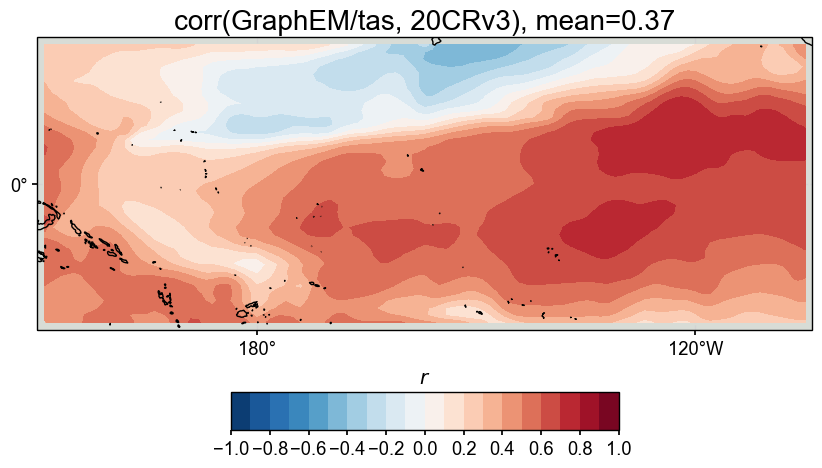

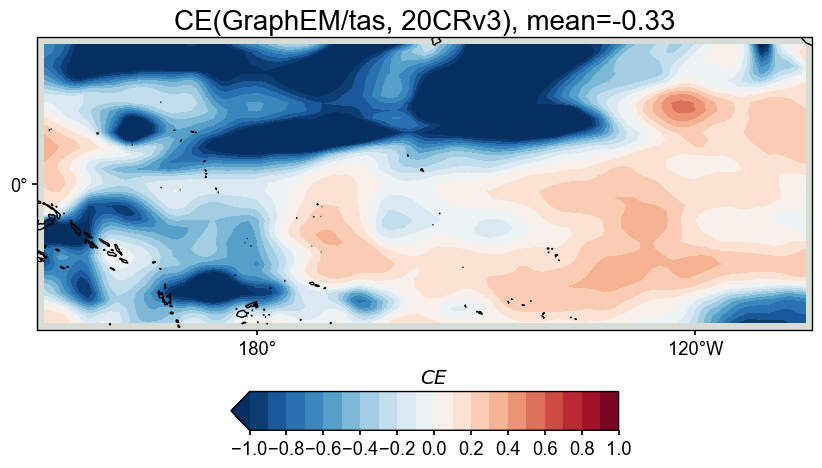

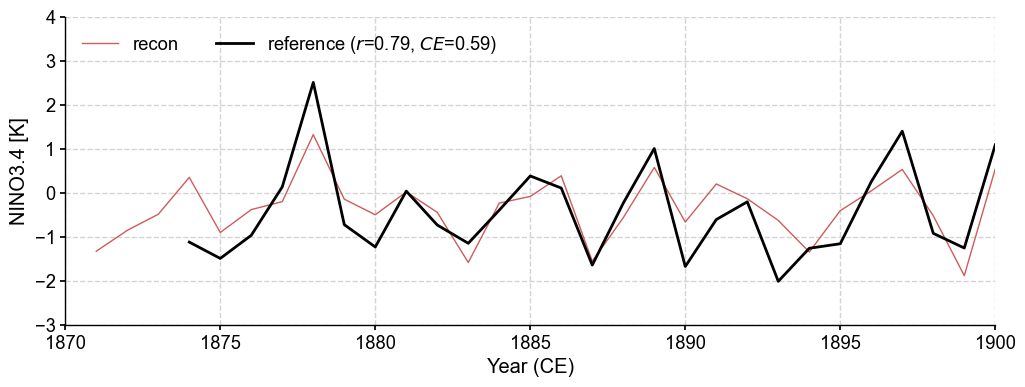

In [11]:
res.valid(
    target_dict={'tas':  tas_20CRv3, 'nino3.4': nino34_bc09},
    timespan=(1874, 1900), verbose=True,
    stat=['corr', 'CE'],
)

fig, ax = res.plot_valid(
    target_name_dict={'tas': '20CRv3', 'nino3.4': 'BC09'},
    recon_name_dict={'tas': 'GraphEM/tas', 'nino3.4': 'NINO3.4 [K]'},
    valid_fd_kws=dict(
        projection='PlateCarree',
        latlon_range=(-20, 20, 150, 256),
        plot_cbar=True,
    ),
    valid_ts_kws=dict(
        xlim = (1870, 1900),
        ylim = (-3, 4),
    )
)